#LAB 5-2: Training ViT with Data Augmentation


<h2><span style="color:blue">[201924497] [ShinByeongGeun]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-25 00:15:31.844956


Refer: Niels Rogge [Homepage](https://nielsrogge.github.io/)

credits:


- 논문: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929
- 모델 구현: this notebook loads (and is inspired by) Niels Rogge's amazing work.



## 문제 정의
CIFAR-10 dataset에 대한 성능을 높이기 위한 다양한 image data augmentation을 사용해보게 됩니다. Data augmentation은 diverse한 image 생성을 통해 overfitting 방지하거나, 일종의 interpolation을 통한 data distribution 공간을 보다 dense하게 만드는 효과를 내 학습을 쉽게 하는 등의 효과가 있습니다. 이 과제에서는 무작위로 augmentation을 적용하는 것 보다, 학습 dataset 특성에 맞는 다양한 augmentation을 적용해보고 그 효과를 평가해보는 것이 목표입니다.

### 데이터셋 개요 및 저작권 정보

사전 학습된 Vision Transformer를 CIFAR-10 데이터셋에 대해 파인튜닝할 것입니다. 이 데이터셋은 10개의 클래스로 구성된 60,000개의 32x32 컬러 이미지로 이루어져 있으며, 각 클래스당 6,000개의 이미지를 포함하고 있습니다.

데이터는 [🤗 datasets](https://github.com/huggingface/datasets)을 사용하여 준비하고, [PyTorch Lightning ⚡](https://github.com/PyTorchLightning/pytorch-lightning)을 사용하여 학습할 것입니다.

- CIFAR-10 데이터셋은 MIT 라이센스에 따라 배포됩니다.
- Hugging Face Datasets 라이브러리는 Apache 2.0 라이센스에 따라 배포됩니다. (https://www.apache.org/licenses/LICENSE-2.0)
- PyTorch Lightning은 Apache 2.0 라이센스에 따라 배포됩니다. (https://github.com/PyTorchLightning/pytorch-lightning/blob/master/LICENSE)




### Quick intro: Vision Transformer (ViT) by Google Brain

Vision Transformer (ViT)는 기본적으로 BERT를 이미지에 적용한 것입니다. SOTA를 찍은 CNN 보다 더 뛰어난 성능을 나타냅니다. 모델에 이미지를 제공하기 위해 각 이미지는 고정 크기 패치(일반적으로 16x16 또는 32x32 해상도)로 분할되며, 이러한 패치들은 선형적으로 임베딩됩니다. 또한, 시퀀스의 시작 부분에 [CLS] (Classfication) 토큰을 추가하여 이미지를 분류합니다. 그 다음, 절대 위치 임베딩을 추가하고 이 시퀀스를 Transformer 인코더에 넣어줍니다.

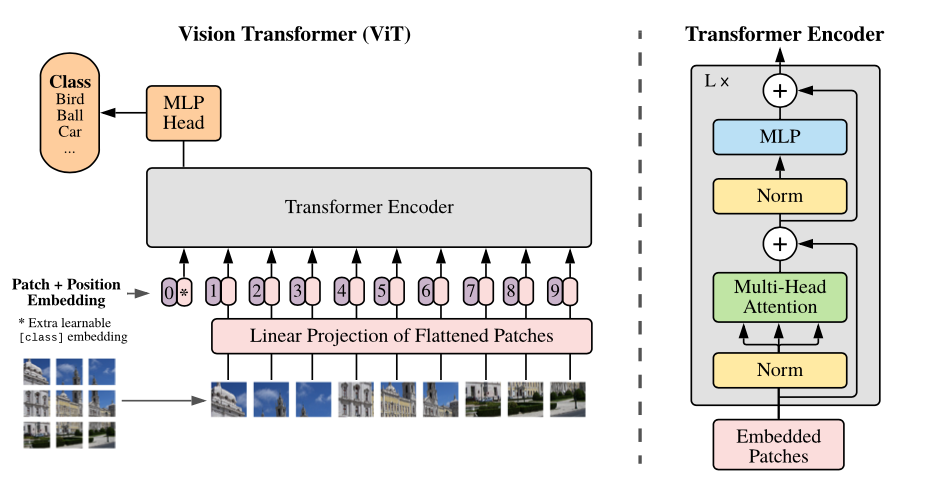

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer


Library 설치

In [2]:
!pip install -q transformers datasets pytorch-lightning

## Load the data

여기서는 시연 목적으로 CIFAR-10의 작은 부분만 가져옵니다. 이 데이터셋은 [hub](https://huggingface.co/datasets/cifar10)에서 찾을 수 있으며, 브라우저에서 이미지를 직접 볼 수 있습니다!

In [3]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4500
})

데이터셋의 특징(feature)을 더 자세히 확인할 수도 있습니다:



In [5]:
train_ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

보시다시피, 각 예제는 두 가지 특징을 가지고 있습니다: 'img' (이미지의 타입)와 'label' (클래스 라벨의 타입)입니다. 이제 학습 데이터셋의 예제를 확인해 보겠습니다:

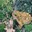

In [6]:
train_ds[0]['img']

In [7]:
train_ds[0]['label']

6

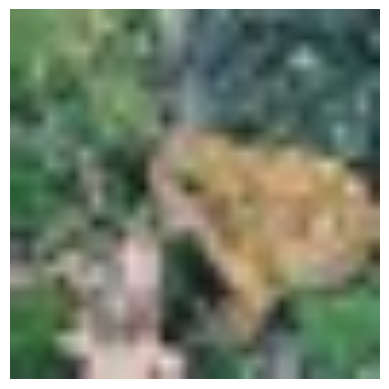

In [8]:
# Visualize 32x32 image to 224x224
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

original_img = train_ds[0]['img']

# 이미지 크기를 224x224로 변환하는 변환기를 정의합니다
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 이미지를 변환합니다
transformed_img = transform(original_img)

# 텐서를 이미지로 변환합니다
transformed_img = transforms.ToPILImage()(transformed_img)

# 이미지를 시각화합니다
plt.imshow(transformed_img)
plt.axis('off')  # 축을 표시하지 않습니다
plt.show()

정수 인덱스 대신 실제 클래스 이름을 알고 싶기 때문에 이를 위해 정수 인덱스와 실제 클래스 이름을 매핑하는 딕셔너리(id2label)를 생성할 수 있습니다

In [9]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [10]:
id2label[train_ds[0]['label']]

'frog'

## Preprocessing the data

이제 데이터를 전처리할 것입니다. 모델은 `pixel_values` 와 `labels`이 필요합니다.

HuggingFace Datasets의 set_transform 메서드(Method)를 사용하여 실시간으로 데이터 증강(Augmentation)을 수행할 것입니다 (관련 문서는 [여기서](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform) 확인할 수 있습니다). 이 메서드(Method)는 일종의 게으른 맵핑 방식으로, 예제가 접근될 때만 변환이 적용됩니다. 이는 텍스트를 토크나이징(Tokenizing)하거나 패딩(Padding)하는 것, 또는 학습 시간에 이미지를 증강(Augmentation)하는 것과 같은 작업에 편리합니다. 여기서도 이러한 방식으로 이미지를 증강(Augmentation)할 것입니다.

먼저 이미지를 추론을 위해 준비할 수 있는 최소한의 객체인 이미지 프로세서를 로드합니다. 모델에 이미지를 준비하기 위해 필요한 속성들을 사용할 것입니다.

In [11]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

### Applying augmentations

데이터 증강을 위해 사용할 수 있는 다양한 라이브러리가 있습니다. 여기서는 torchvision의 [transforms module](https://pytorch.org/vision/stable/transforms.html)을 사용할 것입니다.



In [12]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            #############################################################
            # TODO: 다양한 Augmentation을 적용해 보세요
            RandomHorizontalFlip(),
            RandomRotation(30),
            RandomResizedCrop(size),
            Resize(size),
            ToTensor(),
            normalize,
            #############################################################
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [13]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)


다음과 같이 실시간으로 전처리된 이미지를 로드할 수 있습니다:

In [14]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [6, 3],
 'pixel_values': [tensor([[[-0.3569, -0.3569, -0.3569,  ..., -0.1373, -0.1373, -0.1373],
           [-0.3569, -0.3569, -0.3569,  ..., -0.1373, -0.1373, -0.1373],
           [-0.3569, -0.3569, -0.3569,  ..., -0.1373, -0.1373, -0.1373],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
  
          [[-0.1451, -0.1451, -0.1451,  ...,  0.0980,  0.0980,  0.0980],
           [-0.1451, -0.1451, -0.1451,  ...,  0.0980,  0.0980,  0.0980],
           [-0.1451, -0.1451, -0.1451,  ...,  0.0980,  0.0980,  0.0980],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.

### Visualizing augmentated images

다양한 augmentation을 적용한 이후에는, 원하는 augmentation이 잘 적용되고 있는지 확인해보는 과정이 필수적입니다. Augmentation 뿐만 아니라, Computer Vision의 다양한 모델들을 구현할 때는 모델의 input, output image나 중간 feature map을 시각화해보는 것이 아주 중요합니다. 이를 통해, 사소한 실수를 방지할 수 있을 뿐 아니라, loss로는 파악하기 힘든 모델의 성능 및 강점/약점을 파악할 수 있기 때문입니다.

따라서, 이번에는 augmentation이 잘 적용되었는지 확인해보는 코드를 작성해봅니다.



*   **TO DO**: 직접 정의한 augmentation을 적용한 train dataset과 augmentation을 적용하지 않는 val dataset 중 아무 이미지나 하나씩 load 하여 이미지들을 직접 확인할 수 있는 코드를 작성해주세요.

*   **Hint 1**: 'img'는 augment 되기 전 원본 이미지이며, 'pixel_values' 가 augment된 이미지입니다.
*   **Hint 2**: 이미지의 channel order를 고려해야 합니다. cv2의 경우는 default channel order가 BGR인데 반해, PyTorch에서는 일반적으로 RGB order로 학습을 진행하는 경우가 많습니다. 컬러 이미지의 경우 이러한 차이가 큰 문제로 이어질 수 있습니다. 가령, RGB 이미지로 학습을 진행하고 *cv2.imread()*로 이미지를 불러와 그대로 model에 넣어주는 경우 모델이 아주 낮은 성능을 기록할 수 있습니다.
*   **Hint 3** : 각 dimension이 무엇을 나타내는지도 고려해야 합니다. cv2는 (height, width, channel) 순서로 이미지를 처리하지만, torch의 *conv2d* layer의 경우 (batch, channel, height, width) 순서의 tensor를 입력받습니다. 따라서, *permute()* 같은 함수를 통해 channel 순서를 바꿔주거나, *torch.squeeze(), torch.unsqueeze(), np.newaxis()*등을 dummy batch dimension을 생성/제거해주는 경우도 많이 있습니다.
*  **Hint 4** : 아직 이미지를 GPU에 올리지 않아 해당되지 않는 사항이지만, GPU에 올라간 이미지는 바로 *.cpu()*와 같은 함수를 통해 cpu에 올린 이후 ndarray로 변환해야 하는 경우도 있습니다. 또, gradient가 계산되는 경우는 *.detach()*와 같은 함수를 사용해야 할 수도 있습니다.

이미지를 확인해보기 위해 위 힌트들이 모두 필요할 수도, 아닐 수도 있습니다. 본인이 augmentation을 구현한 방법을 잘 고려해서 본인의 방식대로 이미지를 확인해보면 됩니다. 다만, 위 힌트들은 일반적으로 확인해야 하는 경우가 많기 때문에 관련 내용을 확인해보시는 것을 추천드립니다.




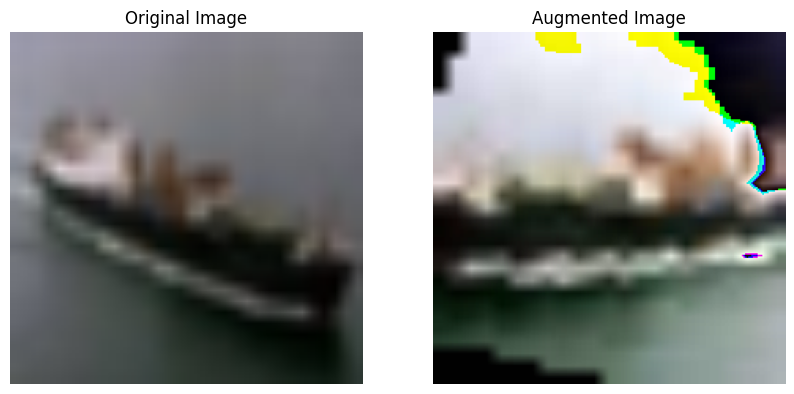

In [20]:
viz_data = train_ds[3]
original_image = viz_data['img']
augmented_image = viz_data['pixel_values']

transform = transforms.Resize((224, 224))
original_image = transform(original_image)
augmented_image = transform(augmented_image)

#############################################################
# TODO: plt를 활용하여 이미지를 직접 확인할 수 있는 코드를 작성하세요
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(transforms.ToPILImage()(augmented_image))
axes[1].set_title("Augmented Image")
axes[1].axis('off')

plt.show()
#############################################################

다음과 같이 해당 PyTorch DataLoader를 매우 쉽게 생성할 수 있습니다:

In [21]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [23]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [24]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([2, 3, 224, 224])

## Define the model

여기서는 LightningModule을 정의합니다. 이는 일반적인 nn.Module과 매우 유사하지만 몇 가지 추가 기능을 제공합니다.

모델 자체는 사전 학습된 ViTModel 위에 선형 레이어(Linear layer)를 사용하는 방식입니다. 마지막 숨겨진 상태의 [CLS] 토큰 위에 선형 레이어를 배치하는데, 이는 전체 이미지를 잘 나타내는 역할을 합니다. 또한 정규화(regularization)를 위해 드롭아웃(dropout)을 추가합니다.

PyTorch Lightning을 이해하는 데 도움이 된 자료로는 [문서](https://pytorch-lightning.readthedocs.io/en/latest/index.html)와 [튜토리얼 노트북](https://github.com/PyTorchLightning/pytorch-lightning/tree/master/notebooks)이 있습니다


In [25]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule): # nn.Module과 유사한 형태임에 주의해주세요.
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=10,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Train the model with augmented images

이제 augmentation을 적용한 이미지들을 이용해 ViT model을 다시 학습해봅니다. Transform 함수를 다양하게 만들어 실험을 해보면서 Augmetation을 적용한 경우와 그렇지 않은 경우, 학습이 어떻게 진행되는지를 tensorboard를 통해 확인해보세요. 단순히 augmentation을 이것저것 적용해보면서 그 중 loss가 가장 낮게 나온 것을 고르는 것 보다는 결과가 좋아졌다면 왜 좋아졌는지, 나빠졌다면 왜 나빠졌는지 나름의 이유를 고민해보시는 것이 중요합니다. 또, 필요한 경우에 loss 그래프만 보는 것 대신 위에서 해본 것 처럼 model의 output을 직접 확인해보면서, 어떤 경우에 model이 더 좋아지거나 나빠졌는지 확인해보세요.



먼저 Tensorboard를 시작해봅시다 (PyTorch Lightning은 기본적으로 Tensorboard에 로그를 기록합니다):

학습 중에 Logits 을 확인하고 싶으면 Tensorboard의 오른쪽 상단에 새로고침 화살표를 눌러 확인할 수 있습니다.

In [27]:
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 20.4 MB/s eta 0:00:00a 0:00:01


In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

Reusing TensorBoard on port 6007 (pid 2575512), started 0:02:05 ago. (Use '!kill 2575512' to kill it.)

모델을 초기화하고, 학습을 시작해봅시다!

또한 콜백을 추가합니다:

얼리 스토핑, early stoppping (검증 손실이 3번 연속 개선되지 않으면 학습을 중지합니다).

In [31]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(max_epochs=1, accelerator="auto", callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
/home/team116/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/team116/miniconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.
/home/team116/miniconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


학습된 모델을 테스트 세트에서 테스트해봅시다:

In [32]:
trainer.test()

/home/team116/miniconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/team116/lab/lightning_logs/version_0/checkpoints/epoch=0-step=2250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
Loaded model weights from the checkpoint at /home/team116/lab/lightning_logs/version_0/checkpoints/epoch=0-step=2250.ckpt
/home/team116/miniconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to impr

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9035000205039978
        test_loss           0.3945622146129608
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3945622146129608, 'test_accuracy': 0.9035000205039978}]

## Some other methods to improve model performance
Augmentation을 적용한 모델의 결과가 더 좋아졌나요? 성능이 향상되었다면 축하드리며, 성능이 좋아지지 않거나 오히려 나빠졌더라도 괜찮습니다. 중요한 것은 augmentation으로 이 과제 코드에서 성능을 얼마나 올렸는지가 아니라, 다음에 다른 dataset, 다른 model로 학습을 진행할 때 필요한 augmentation을 생각해낼 수 있는 나름의 성공/실패 경험과 이유를 만드는 것이기 때문입니다.

데이터의 특성 및 모델의 특성을 반영할 수 있는 몇가지 추가 질문들입니다. 아래 질문들에 대해 나름의 답을 생각해보시고, 직접 실험해보면서 다음에 새로운 데이터셋과 모델을 만난다면 어떤 augmentation을 왜 적용해야 할지, 나름대로의 이유를 생각해보시고, 실험해보시고, 다른 캠퍼분들과 토의해보세요.

1. CIFAR-10 데이터셋은 다양한 물체의 이미지를 포함하고 있습니다. 이런 경우, 색상 변화나 대비 조정 등의 색상 변환(color augmentation)을 적용하면 성능 향상에 도움이 될 수 있습니다. 왜 색상 변환이 모델 성능 향상에 도움이 되는지 생각해보세요.

2. Augmentation의 순서 역시 중요한 요소가 될 수 있습니다. 색상 변환을 먼저 적용하고 이미지를 회전시키는 경우와 이미지를 회전시키고 나서 색상 변환을 적용하는 경우, 이미지가 어떻게 달라질지 예상해보시고, 실제 augmentation 패키지에 따라 결과가 어떻게 나타나는지도 확인해보세요. 그리고 기하학적 변환(geometric augmentation)의 경우에도 순서가 어떻게 영향을 미칠지 생각해보세요.

3. Augmentation을 적용했음에도, ViT 모델의 사전 학습된 부분을 고정하고 분류기만 새로 학습하는 fine-tuning을 수행하면 augmentation의 효과가 떨어질 수 있습니다. 그 이유에 대해 생각해보세요.

**TO DO (3-1)** : 위 further question에 대해 고민해보고, 직접 실험해보며 결과를 확인해보세요.

1. 색상 변환이 모델 성능 향상에 도움이 되는 이유는?

--- 기본적으로 훈련 데이터셋이 가지고 있는 각 물체는 특정한 색상 패턴을 갖는다. 색상 변환을 적용하면, 모델은 특정 색상에 의존하지 않고 더 넓은 범위의 색상을 처리할 수 있게 된다. 이로 인해 모델은 색상에 대해 더 일반화된 특성을 학습하게 되어, 실제 추론 시 더 다양한 환경에 대해 잘 대응할 수 있는 능력을 갖추게 된다. 또한, 색상 변화는 특히 실생활에서 다양한 조명 환경이나 색조 변화에 직면하는 상황에서 모델의 성능을 향상시킬 수 있다.

2. Augmentation의 순서가 이미지에 미치는 영향은?

--- Augmentation의 순서는 이미지의 변환 결과에 큰 영향을 미친다. 예를 들어, 색상 변환을 먼저 적용하고 나서 이미지를 회전시키면 색상의 변형이 고정된 상태에서 회전이 이루어지게 되어, 색상 변화가 이미지의 구석구석에 고르게 영향을 미친다. 반면 이미지를 먼저 회전시키고 나서 색상 변환을 적용하면, 회전 후의 이미지에서 색상이 변형되므로 이미지의 색상 분포가 다르게 나타날 수 있다. 기하학적 변환의 경우, 이미지 회전 후 색상 변환을 적용하는 방식이 더 일관된 색상 변화 결과를 도출할 수 있다. 

3. 사전 학습된 ViT 모델의 일부를 고정하고 분류기만 새로 학습할 때 augmentation의 효과가 떨어질 수 있는 이유는?

--- 사전 학습된 ViT 모델의 일부를 고정하고 분류기만 새로 학습하는 방식에서는, 이미 사전 학습을 통해 잘 일반화된 특성들을 고정시키고 있기 때문에 augmentation의 효과가 제한적일 수 있다. 이러한 설정에서는 모델이 이미 이전 학습을 통해 충분히 일반화된 표현을 갖추고 있어, 추가적인 데이터 증강을 통해 얻을 수 있는 변화된 특성들이 모델에 미치는 영향이 작아질 수 있다. 또한, ViT 모델은 강력한 특성 추출 능력을 가지고 있으므로, 분류기만 학습하더라도 이미 중요한 특성들이 잘 파악되고, augmentation이 그 특성을 바꾸는 데에 큰 영향을 미치지 않을 수 있다.








